In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/patents/training_set_patents_disambiguation_V1.tsv


# 1. Data Preparation

## 1.1 Data Preprocessing

In [2]:
# load the patents dataset
patents = pd.read_csv('/kaggle/input/patents/training_set_patents_disambiguation_V1.tsv', sep='\t')

# drop unused columns
drop_columns = ['Unnamed: 0', 'disambig_inventor_name_first', 'disambig_inventor_name_last', 'patent_title', 'patent_abstract']
patents = patents.drop(drop_columns, axis=1)

# merge title_encoded and abstract_encoded into text_encoded
patents['patent_text_encoded'] = patents['patent_title_encoded'] + patents['patent_abstract_encoded']

# show the dataframe
patents.head(5)

,patent_id,inventor_id,patent_date,patent_title_encoded,patent_abstract_encoded,patent_text_encoded
0,10000008,fl:li_ln:caspi-2,2018-06-19,[-0.033 0.094 0.013 -0.038 -0.114 -0.022 0....,[-0.047 0.042 0. 0.02 -0.094 0.016 0....,[-0.033 0.094 0.013 -0.038 -0.114 -0.022 0....
1,10000021,fl:is_ln:fuwa-1,2018-06-19,[ 0.034 -0.032 -0.061 -0.043 -0.09 -0.094 -0....,[-0. -0.028 -0.032 -0.025 -0.074 -0.036 -0....,[ 0.034 -0.032 -0.061 -0.043 -0.09 -0.094 -0....
2,10000023,fl:al_ln:elsiblani-1,2018-06-19,[ 0.004 -0.061 -0.053 -0.036 -0.128 -0.056 -0....,[-0.035 -0.039 -0.015 -0.043 -0.108 -0.057 0....,[ 0.004 -0.061 -0.053 -0.036 -0.128 -0.056 -0....
3,10000030,fl:ma_ln:ohara-21,2018-06-19,[-0.073 0.05 -0.06 -0.043 -0.048 -0.054 -0....,[ 0.032 0.008 0.004 -0.028 0.02 -0.011 -0....,[-0.073 0.05 -0.06 -0.043 -0.048 -0.054 -0....
4,10000038,fl:no_ln:mukai-13,2018-06-19,[-0.07 0.038 -0.033 0.043 -0.058 -0.005 0....,[-0.073 0.074 0.032 -0.003 0.025 0.029 0....,[-0.07 0.038 -0.033 0.043 -0.058 -0.005 0....


In [3]:

# convert word vector to a cleaned numpy array
def preprocess_data(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    
    # Make a copy of the dataframe to avoid changing the original one
    df_copy = df.copy()

    for i in range(len(df_copy[column_name])):

        data = df_copy[column_name][i].strip('[]').replace('][', ' ')

        # Split by spaces
        data = data.split()

        # Convert strings to float32
        data = np.array(data, dtype=np.float32)

        # Assign the preprocessed data back to the DataFrame
        df_copy.at[i, column_name] = data

    return df_copy

In [4]:
patents = preprocess_data(patents, 'patent_title_encoded')
patents = preprocess_data(patents, 'patent_abstract_encoded')
patents = preprocess_data(patents, 'patent_text_encoded')

In [5]:
inventor_counts = patents['inventor_id'].value_counts()
inventor_counts

fl:ae_ln:dudar-1            15
fl:ge_ln:vanlieshout-2      12
fl:ho_ln:zhang-167          12
fl:al_ln:reznicek-1         12
fl:eu_ln:lee-264            12
                            ..
fl:bi_ln:bhattacharyya-5     2
fl:ke_ln:ash-7               2
fl:an_ln:smith-44            2
fl:an_ln:freed-1             2
fl:gr_ln:sesselmann-1        2
Name: inventor_id, Length: 2663, dtype: int64

In [6]:
patents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6353 entries, 0 to 6352
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patent_id                6353 non-null   int64 
 1   inventor_id              6353 non-null   object
 2   patent_date              6353 non-null   object
 3   patent_title_encoded     6353 non-null   object
 4   patent_abstract_encoded  6353 non-null   object
 5   patent_text_encoded      6353 non-null   object
dtypes: int64(1), object(5)
memory usage: 297.9+ KB


## 1.2 Train and Test Dataset Splitting

In [7]:
# Set 'patent_id' as the index
# patents.set_index('patent_id', inplace=True)

# Shuffle the dataset
# patents = patents.sample(frac=1).reset_index(drop=True)

from sklearn.model_selection import train_test_split
# Split the dataset into train and test sets
train_patents, test_patents = train_test_split(patents, test_size=0.2, random_state=42)
train_patents.head()

,patent_id,inventor_id,patent_date,patent_title_encoded,patent_abstract_encoded,patent_text_encoded
5310,10028772,fl:na_ln:meyer-3,2018-07-24,"[-0.049, 0.007, 0.017, -0.064, -0.168, -0.039,...","[-0.069, -0.026, 0.049, -0.028, -0.136, -0.028...","[-0.049, 0.007, 0.017, -0.064, -0.168, -0.039,..."
1128,10006491,fl:ke_ln:yuda-2,2018-06-26,"[-0.039, 0.0, -0.018, -0.045, -0.062, 0.024, -...","[-0.085, 0.005, 0.064, 0.019, 0.005, 0.023, -0...","[-0.039, 0.0, -0.018, -0.045, -0.062, 0.024, -..."
5936,10032716,fl:ch_ln:yang-76,2018-07-24,"[-0.042, 0.09, 0.02, 0.02, -0.024, -0.026, 0.0...","[-0.088, 0.107, 0.073, -0.01, 0.021, -0.017, 0...","[-0.042, 0.09, 0.02, 0.02, -0.024, -0.026, 0.0..."
1550,10008706,fl:ch_ln:murakami-2,2018-06-26,"[-0.065, 0.101, -0.103, -0.039, 0.04, 0.003, 0...","[-0.054, 0.114, -0.068, -0.073, 0.015, -0.038,...","[-0.065, 0.101, -0.103, -0.039, 0.04, 0.003, 0..."
57,10000489,fl:as_ln:hancock-1,2018-06-19,"[-0.074, -0.095, -0.055, -0.023, 0.055, 0.004,...","[-0.024, 0.053, -0.027, 0.017, 0.045, 0.073, 0...","[-0.074, -0.095, -0.055, -0.023, 0.055, 0.004,..."


In [8]:
import random

# Create anchor, positive, and negative datasets
def prepare_triplet_data(data):
    # Initialize empty lists for anchor, positive, and negative samples
    anchor_samples = []
    positive_samples = []
    negative_samples = []

    # Group data by inventor_id
    grouped_data = data.groupby('inventor_id')

    for group_name, group_data in grouped_data:
        # If the group has only one sample, skip it (cannot form positive pair)
        if len(group_data) < 2:
            continue

        # Select a random anchor sample
        anchor_sample = group_data.sample(n=1)

        # Select another random sample from the same group as positive pair
        positive_sample = group_data.sample(n=1)

        # Select a random sample from a different group as negative pair
        group_names = list(grouped_data.groups.keys())
        negative_group_name = random.choice(group_names)
        negative_group = grouped_data.get_group(negative_group_name)
        negative_sample = negative_group.sample(n=1)

        # Append samples to the respective lists
        anchor_samples.append(anchor_sample)
        positive_samples.append(positive_sample)
        negative_samples.append(negative_sample)

    # Concatenate the anchor, positive, and negative samples
    anchor_data = pd.concat(anchor_samples)
    positive_data = pd.concat(positive_samples)
    negative_data = pd.concat(negative_samples)

    return anchor_data, positive_data, negative_data


In [9]:
# Prepare the triplet data for training and testing
anchor_train, positive_train, negative_train = prepare_triplet_data(train_patents)
anchor_test, positive_test, negative_test = prepare_triplet_data(test_patents)
anchor_train.shape, anchor_test.shape

((1868, 6), (167, 6))

In [10]:
def convert_to_numpy_array(df_train: pd.DataFrame, df_test: pd.DataFrame, column_name: str):
    # Convert train data to a single numpy array
    train_data = np.array(df_train[column_name])
    train_data = np.vstack(train_data)

    # Convert test data to a single numpy array
    test_data = np.array(df_test[column_name])
    test_data = np.vstack(test_data)
    
    return train_data, test_data

In [11]:
anchor_train_data, anchor_test_data = convert_to_numpy_array(anchor_train, anchor_test, 'patent_abstract_encoded')
positive_train_data, positive_test_data = convert_to_numpy_array(positive_train, positive_test, 'patent_abstract_encoded')
negative_train_data, negative_test_data = convert_to_numpy_array(negative_train, negative_test, 'patent_abstract_encoded')

In [12]:
anchor_train_data, anchor_test_data

(array([[-0.024, -0.021,  0.007, ...,  0.013, -0.087,  0.023],
        [ 0.035, -0.041, -0.036, ...,  0.105,  0.025, -0.047],
        [-0.019,  0.006, -0.065, ...,  0.138, -0.012, -0.071],
        ...,
        [-0.025, -0.002, -0.014, ...,  0.061,  0.085,  0.006],
        [-0.07 , -0.119, -0.027, ...,  0.083,  0.009, -0.035],
        [-0.089,  0.026, -0.014, ...,  0.065,  0.028, -0.045]],
       dtype=float32),
 array([[ 0.023,  0.009,  0.045, ...,  0.024,  0.199, -0.065],
        [-0.024, -0.003,  0.018, ...,  0.113, -0.013,  0.013],
        [-0.021,  0.033, -0.042, ...,  0.033, -0.007, -0.151],
        ...,
        [ 0.023,  0.011, -0.055, ...,  0.143, -0.024,  0.057],
        [-0.109,  0.044,  0.04 , ...,  0.04 ,  0.014,  0.011],
        [-0.044,  0.026, -0.08 , ...,  0.078,  0.048,  0.008]],
       dtype=float32))

In [13]:
anchor_train_data.shape, anchor_test_data.shape

((1868, 384), (167, 384))

# 2. Model Training and Testing

## 2.1 Model Construction

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras import backend as K
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, concatenate
from keras.optimizers import RMSprop
from keras import regularizers

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [15]:
# ! pip install tensorflow-addons

In [16]:
# Create a batch of base neural networks
# MLP, 1D-CNN, LSTM, GRU, RNN, Transformer

# simple MLP

def base_MLP(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape= (input_shape,)))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))

    return model

# 1d-CNN

from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Sequential

def base_CNN(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    model = Sequential()
    model.add(Conv1D(128, 5, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.1))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.1))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalAveragePooling1D())
    
    return model

# LSTM
from keras.layers import LSTM
def base_LSTM(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(128, return_sequences=False))
    
    return model

# GRU 
from keras.layers import GRU

def base_GRU(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(GRU(128, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(GRU(128, return_sequences=False))
    
    return model

# Simple RNN

from keras.layers import SimpleRNN

def base_RNN(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    model = Sequential()
    model.add(SimpleRNN(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(SimpleRNN(128, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(SimpleRNN(128, return_sequences=False))
    
    return model

In [17]:
# Distance/Similarity calculating functions

def euclidean_distance(x1, x2):
    return tf.norm(x1 - x2, axis=-1)

def cosine_similarity(x1, x2):
    x1 = K.l2_normalize(x1, axis=-1)
    x2 = K.l2_normalize(x2, axis=-1)
    return 1.0 - K.sum(x1 * x2, axis=-1)

In [18]:
# Loss functions

def triplet_loss(_, distances):
    margin = 0.5
    distance_positive = distances[1]
    distance_negative = distances[2]
    loss = K.mean(K.maximum(distance_positive - distance_negative + margin, 0.0))
    return loss

In [19]:
# Create the Siamese network model with the base model

def siamese_network(base_model, distance_fn):
    input_anchor = Input(shape=base_model.input_shape[1:])
    input_positive = Input(shape=base_model.input_shape[1:])
    input_negative = Input(shape=base_model.input_shape[1:])
    
    embedded_anchor = base_model(input_anchor)
    embedded_positive = base_model(input_positive)
    embedded_negative = base_model(input_negative)

    # Distance calculation using the provided distance function
    distance_positive = Lambda(lambda x: distance_fn(x[0], x[1]), name='pos_dist')([embedded_anchor, embedded_positive])
    distance_negative = Lambda(lambda x: distance_fn(x[0], x[1]), name='neg_dist')([embedded_anchor, embedded_negative])
    
    # Concatenate the outputs
    merged_output = Concatenate()([embedded_anchor, embedded_positive, embedded_negative])

    # Model combining anchor, positive, and negative inputs
    siamese_model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=[merged_output, distance_positive, distance_negative])

    return siamese_model

In [20]:
import tensorflow as tf
import os

def train_siamese_network(anchor_data, positive_data, negative_data, base_model, batch_size, epochs, 
                          distance_fn, use_gpu=True, use_tpu=False):
    
    if use_gpu:
        siamese_model = siamese_network(base_model, distance_fn)
        siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=[None, triplet_loss, triplet_loss], loss_weights=[0, 1, 1])
        
    elif use_tpu:
        # Code for TPU training
        tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu_resolver)
        tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
        strategy = tf.distribute.TPUStrategy(tpu_resolver)
        
        with strategy.scope():
            siamese_model = siamese_network(base_model, distance_fn)
            siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=[None, triplet_loss, triplet_loss], loss_weights=[0, 1, 1])
    
    else:
        siamese_model = siamese_network(base_model, distance_fn)
        siamese_model.compile(optimizer='adam', loss=[None, triplet_loss, triplet_loss], loss_weights=[0, 1, 1])

    dummy_target = np.zeros((anchor_data.shape[0], 1), dtype=np.float32)

    siamese_model.fit([anchor_data, positive_data, negative_data], 
                      [dummy_target, dummy_target, dummy_target], 
                       batch_size=batch_size, epochs=epochs, verbose=1)

    return siamese_model

In [21]:
from sklearn.metrics import silhouette_score

def evaluate_clustering(anchor_test_data, num_clusters, siamese_models, base_model_names, distance_fn_names):
    silhouette_scores = []
    table_data = []
    
    num_models = len(siamese_models)

    for i, model in enumerate(siamese_models):

        anchor_test_embeddings = model.layers[3](anchor_test_data)

        kmeans = KMeans(n_clusters=num_clusters, random_state=48).fit(anchor_test_embeddings)
        labels = kmeans.labels_

        silhouette = silhouette_score(anchor_test_embeddings, labels)
        silhouette_scores.append(silhouette)
        
        base_model_name = base_model_names[i // len(distance_fn_names)]
        distance_fn_name = distance_fn_names[i % len(distance_fn_names)]
        combination = f'Model {i+1}: {base_model_name} with {distance_fn_name}'

        print(f'Silhouette Score: {silhouette}')
        pca = PCA(n_components=2)
        principalComponents = pca.fit_transform(anchor_test_embeddings)
        principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
        plt.figure(figsize=(8,6))
        plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=labels)
        plt.title(combination)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        
        #plt.savefig(combination +'.png')
        
        plt.show()

        table_data.append({'Model': combination, 'Silhouette Score': silhouette})

    table_df = pd.DataFrame(table_data)

    return silhouette_scores, table_df

## 2.2 Model Training

In [22]:
# Configurations
input_shape_ = anchor_train_data.shape[1]  # Shape of input data
input_dim = 1 # You might need to change this based on your data
input_shape = (input_shape_, input_dim)

batch_size = 32  # Batch size for training
epochs = 10  # Number of epochs for training
num_clusters = 5  # Number of clusters for K-means

# Define the base models and distance functions
base_models = [base_MLP(input_shape_), base_CNN(input_shape), base_LSTM(input_shape), base_RNN(input_shape)]
distance_fns = [euclidean_distance, cosine_similarity]

base_model_names = ['MLP', 'CNN', 'LSTM', 'RNN']
distance_fn_names = ['Euclidean Distance', 'Cosine Similarity']

In [23]:
#Train and evaluate models for different combinations of base models and distance functions
siamese_models = []

for base_model in base_models:
    print(base_model)
    if base_model == base_CNN(input_shape):
        anchor_train_CNN = anchor_train_data.reshape(-1, input_shape_, input_dim)
        positive_train_CNN = positive_train_data.reshape(-1, input_shape_, input_dim)
        negative_train_CNN = negative_train_data.reshape(-1, input_shape_, input_dim)
        
        for distance_fn in distance_fns:
            siamese_model = train_siamese_network(anchor_train_CNN, positive_train_CNN, negative_train_CNN, base_model, batch_size, epochs, distance_fn)
            siamese_models.append(siamese_model)
        
    else:
        for distance_fn in distance_fns:
            siamese_model = train_siamese_network(anchor_train_data, positive_train_data, negative_train_data, base_model, batch_size, epochs, distance_fn)
            siamese_models.append(siamese_model)

for i, model in enumerate(siamese_models):
    
    name = '/kaggle/working/model' + str(i+1) +'.h5'
    #print(name)
    model.save(name)

Epoch 1/10
59/59 [==============================] - 5s 4ms/step - loss: 0.9720 - pos_dist_loss: 0.4807 - neg_dist_loss: 0.4913
Epoch 2/10
59/59 [==============================] - 0s 4ms/step - loss: 1.0056 - pos_dist_loss: 0.5033 - neg_dist_loss: 0.5023
Epoch 3/10
59/59 [==============================] - 0s 4ms/step - loss: 0.9884 - pos_dist_loss: 0.4921 - neg_dist_loss: 0.4962
Epoch 4/10
59/59 [==============================] - 0s 4ms/step - loss: 0.9676 - pos_dist_loss: 0.4767 - neg_dist_loss: 0.4909
Epoch 5/10
59/59 [==============================] - 0s 4ms/step - loss: 0.9022 - pos_dist_loss: 0.4769 - neg_dist_loss: 0.4253
Epoch 6/10
59/59 [==============================] - 0s 4ms/step - loss: 0.9612 - pos_dist_loss: 0.4624 - neg_dist_loss: 0.4988
Epoch 7/10
59/59 [==============================] - 0s 6ms/step - loss: 1.0420 - pos_dist_loss: 0.5213 - neg_dist_loss: 0.5208
Epoch 8/10
59/59 [==============================] - 0s 6ms/step - loss: 0.9310 - pos_dist_loss: 0.4921 - neg_di

In [24]:
# from tensorflow.keras.models import load_model
# # Load the saved model
# siamese_models = []
# for i in range(len(base_models)*2):
#     model_name = '/kaggle/working/model'+str(i+1)+'.h5'
#     print(model_name)
#     loaded_model = load_model(model_name)
# #     siamese_models.append(loaded_model)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.25774067640304565


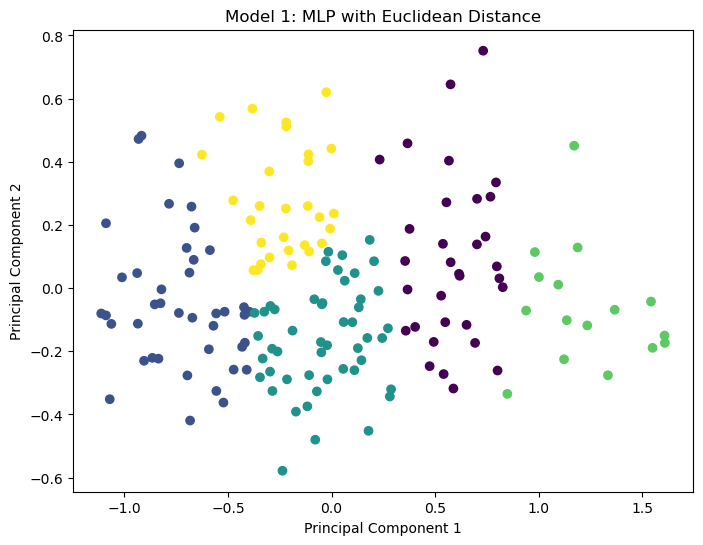

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.25774067640304565


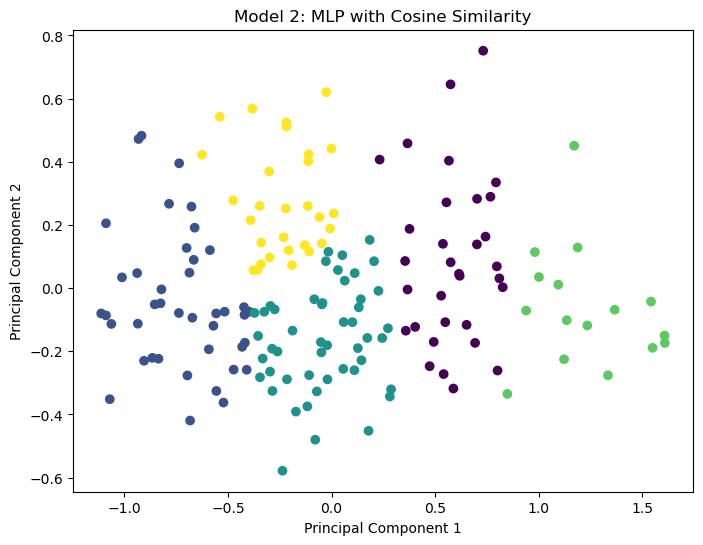

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.4533971846103668


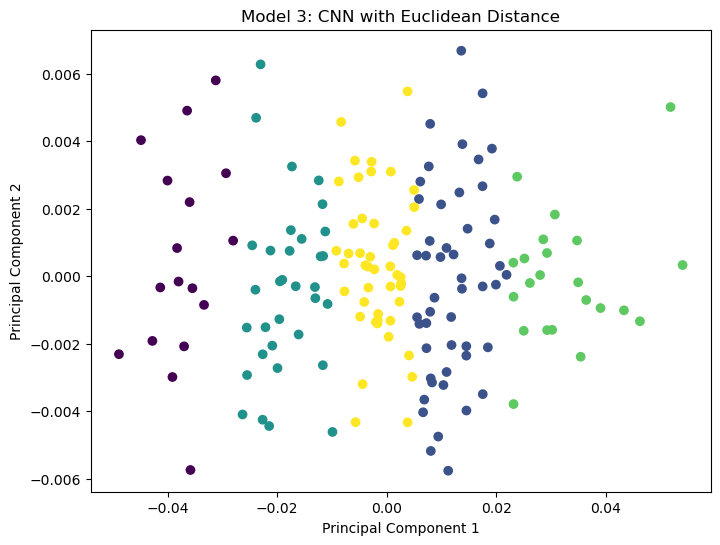

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.4533971846103668


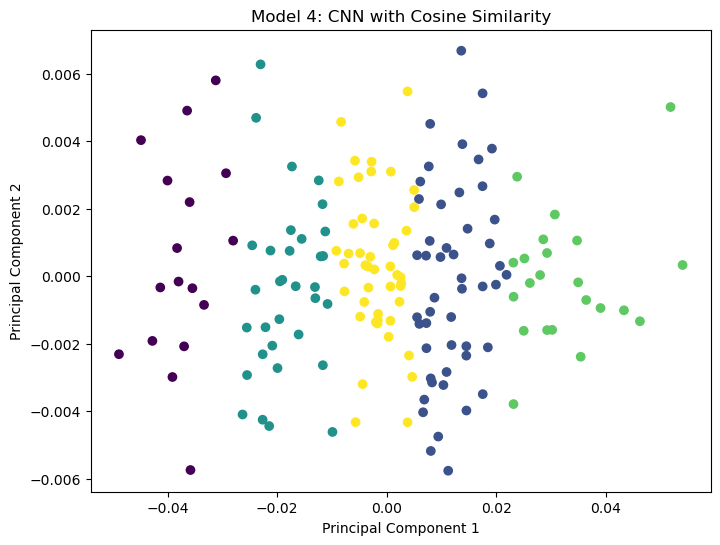

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.4569565951824188


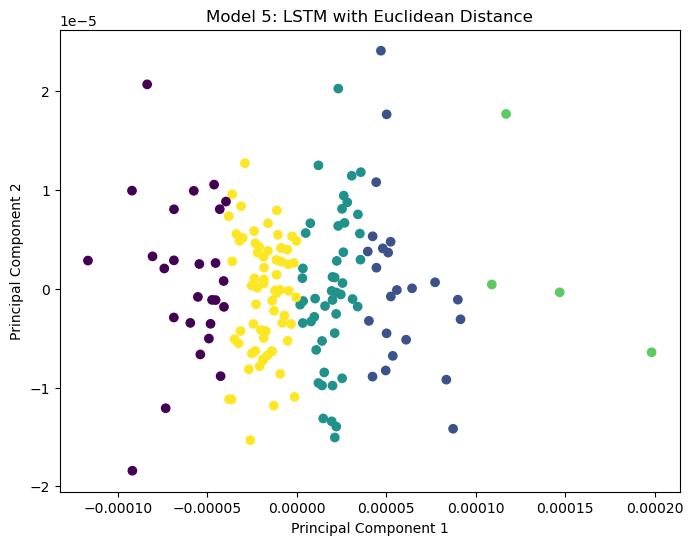

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.4569565951824188


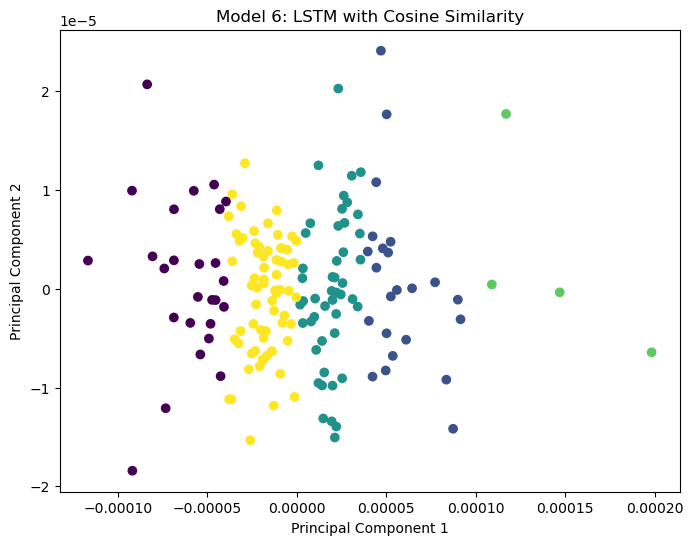

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.45224153995513916


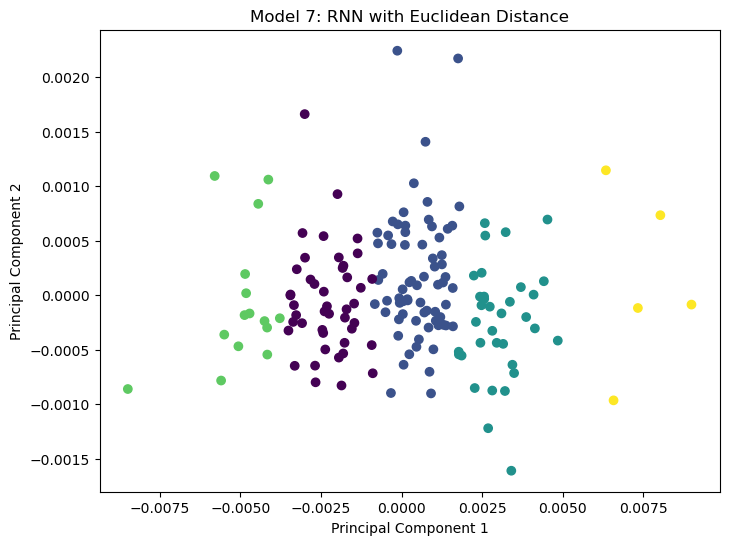

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.45224153995513916


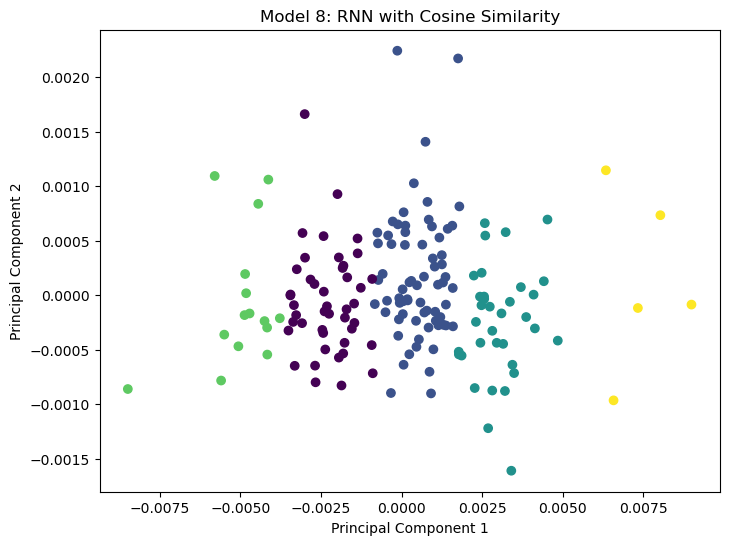

In [25]:
silhouette_scores, results_df = evaluate_clustering(anchor_test_data, num_clusters, 
                                        siamese_models, base_model_names, distance_fn_names)

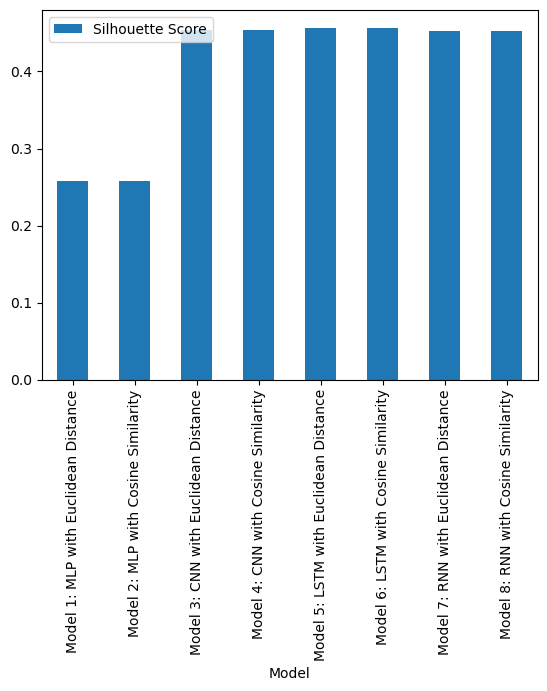

In [26]:
results_df.plot.bar(x='Model', y='Silhouette Score')
plt.savefig('results.png')  # Save the plot as an image file
results_df.to_csv('results.csv', index=False)  # Save the DataFrame as a CSV file

In [27]:
# Find the best combination based on the highest Silhouette Score
best_idx = np.argmax(silhouette_scores)
best_base_model_idx = best_idx // len(distance_fns)
best_distance_fn_idx = best_idx % len(distance_fns)

best_base_model = base_model_names[best_base_model_idx]
best_distance_fn = distance_fn_names[best_distance_fn_idx]

print(f'Best combination: Base Model - {best_base_model}, Distance Function - {best_distance_fn}')
print(f'Highest Silhouette Score: {silhouette_scores[best_idx]}')

Best combination: Base Model - LSTM, Distance Function - Euclidean Distance
Highest Silhouette Score: 0.4569565951824188


In [28]:
anchor_test_embeddings = siamese_models[best_idx].layers[3](anchor_test_data)

kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(anchor_test_embeddings)

labels = kmeans.labels_

silhouette = silhouette_score(anchor_test_embeddings, labels)
print(silhouette)

# Reset index to get 'patent_id' back as a column

anchor_test.reset_index(level=0, inplace=True)

# Create a DataFrame for cluster assignment
clusters_df = pd.DataFrame({'cluster_id': labels})

# Concatenate original test data with cluster assignment
disambiguated_test_data = pd.concat([anchor_test, clusters_df], axis=1)

# Drop colums and only keep patent_id, inventor_id, cluster_id
columns_to_drop = ['patent_date', 'patent_title_encoded', 'patent_abstract_encoded', 'patent_text_encoded']
disambiguated_test_data = disambiguated_test_data.drop(columns=columns_to_drop)

disambiguated_test_data

0.45572448


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,index,patent_id,inventor_id,cluster_id
0,1044,10005955,fl:aa_ln:beuterbaugh-1,4
1,5163,10028168,fl:aa_ln:callard-1,1
2,2098,10011412,fl:aa_ln:misener-1,3
3,4585,10025365,fl:ab_ln:banerjee-1,1
4,3002,10015996,fl:ad_ln:bennett-1,1
...,...,...,...,...
162,2276,10012845,fl:ye_ln:huang-18,0
163,2951,10015807,fl:yo_ln:heo-3,0
164,3770,10020591,fl:yu_ln:uemichi-1,2
165,3820,10020870,fl:zh_ln:fang-41,1


In [29]:
# # Configurations

# input_shape = anchor_train_data.shape[1] # number of data elements

# # Define the number of clusters for K-means
# num_clusters = 5

# input_dim = 1 # You might need to change this based on your data
# input_shape_ = (input_shape, input_dim)

# # input_shape = anchor_train_data.shape[1:] 

# base_model = base_MLP(input_shape)#'MLP'

# # Define the batch size and number of epochs for training
# batch_size = 32
# epochs = 10

# # base_model = base_MLP(input_shape)

# distance_fn = euclidean_distance #cosine_similarity 

# # Define the base models
# base_models = {
#     'MLP': base_MLP(input_shape),
# #     '1D-CNN': base_CNN(input_shape),
# #     'LSTM': base_LSTM(input_shape),
# #     'GRU': base_GRU(input_shape),
# #     'SimpleRNN': base_RNN(input_shape),
# #     'Transformer': base_Transformer(input_shape)
# }

In [30]:
# anchor_train_data = anchor_train_data.reshape(-1, input_shape, input_dim)
# positive_train_data = positive_train_data.reshape(-1, input_shape, input_dim)
# negative_train_data = negative_train_data.reshape(-1, input_shape, input_dim)

In [31]:
# siamese_model = train_siamese_network(anchor_train_data, positive_train_data, negative_train_data, base_model, batch_size, epochs, distance_fn)

In [32]:
# from sklearn.metrics import silhouette_score
# from sklearn.manifold import TSNE

# # Step 1: Compute embeddings of the test set
# anchor_test_embeddings = siamese_model.layers[3](anchor_test_data)

# # Step 2: Cluster the embeddings using K-means
# kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(anchor_test_embeddings)

# # Step 3: Compute the Silhouette Score for the clustering
# labels = kmeans.labels_
# silhouette = silhouette_score(anchor_test_embeddings, labels)

# print(f'Silhouette Score: {silhouette}')

# # Step 4: Visualize the embeddings using PCA
# pca = PCA(n_components=2)
# principalComponents = pca.fit_transform(anchor_test_embeddings)
# principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
# plt.figure(figsize=(8,6))
# plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=labels)
# plt.title('2 component PCA')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

# # Alternatively, you can use t-SNE for visualization
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(anchor_test_embeddings)
# plt.figure(figsize=(8,6))
# plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels)
# plt.title('t-SNE visualization')
# plt.show()

In [33]:
# # Check the disambiguated inventors
# disambiguated_test_data[disambiguated_test_data['cluster_id'] == 2]